In [0]:
import pandas as pd
import seaborn as sns
sns.set()
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from scipy import stats
import sys
from numpy.linalg import inv
import math
from scipy.stats import gamma

In [0]:
#Reading COVID data from API to ensure we always have the latest available data
# url = "https://covidtracking.com/api/v1/states/daily.csv"
full_data = pd.read_csv("daily.csv")

In [0]:
#We henceforth for the purpose of this project, will be working on the combined COVID data of two states - 
#Texas and New Mexico. 
#We do realize these are two different states - we aim to combine the data for these two and do some analysis and find meaningful inferences.
states = ['TX','NM']
texas_newmexico_data = full_data[full_data.state.isin(states)] 

In [0]:
#Adding up rows for texas and new mexico
texas_newmexico_data = texas_newmexico_data.groupby(['date']).sum().reset_index()

In [0]:
#Data Cleaning - Filling null values with 0 as we assume no data was recorded/reported on those days.
#Why we impute with 0 and not with mean, median is better explained in the conclusion towards the end of this task.
texas_newmexico_data = texas_newmexico_data.fillna(0)
# texas_newmexico_data

#Data Cleanup
##Tukey's method of detecting outliers

In [0]:
# Tukey Method to detect outliers
n = 1 #In this case, we considered outliers as rows that have at least one outlier numerical value.
indices = []
for col in texas_newmexico_data.columns[0:26]:
    Q1 = np.percentile(texas_newmexico_data[col],25) #Q1 is at 25 - first quartile
    Q3 = np.percentile(texas_newmexico_data[col],75) #Q3 is at 75 - third quartile
    IQR = Q3 - Q1 #inter-quartile range
    multiplier = 1.5 * IQR #This multiplier works for finding outliers for our data, so we stick to it.
    # Determine a list of indices of outliers for feature col
    list_outliers = texas_newmexico_data[(texas_newmexico_data[col] < Q1 - multiplier) | (texas_newmexico_data[col] > Q3 + multiplier )].index 
    indices.extend(list_outliers) # appending the found outlier indices to the list of outlier indices
indices = Counter(indices)
outliers = list( k for k, v in indices.items() if v > n )

In [0]:
#These are the indices of the rows which had atleast one outlier value
outliers

[55, 56, 51, 52]

In [0]:
#Throwing the outliers - we discard the ones we found
texas_newmexico_data.drop(outliers, axis = 0)
texas_newmexico_data = texas_newmexico_data.drop(outliers, axis = 0).reset_index(drop=True)

In [0]:
# texas_newmexico_data.info()
texas_newmexico_data['state'] = 'TX,NM'
# texas_newmexico_data['date'].unique()
texas_newmexico_data.to_csv("tx_nm_data2.csv")

In [0]:
texas_newmexico_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   date                      53 non-null     int64  
 1   positive                  53 non-null     float64
 2   negative                  53 non-null     float64
 3   pending                   53 non-null     float64
 4   hospitalizedCurrently     53 non-null     float64
 5   hospitalizedCumulative    53 non-null     float64
 6   inIcuCurrently            53 non-null     float64
 7   inIcuCumulative           53 non-null     float64
 8   onVentilatorCurrently     53 non-null     float64
 9   onVentilatorCumulative    53 non-null     float64
 10  recovered                 53 non-null     float64
 11  death                     53 non-null     float64
 12  hospitalized              53 non-null     float64
 13  total                     53 non-null     float64
 14  totalTestRes

##Conclusion
We applied Tukey's rule and found around 4 outlier values, these are mostly the ones where there was a sudden spike in the positive or negative cases. In few cases, these were even when the data reported a relatively low (0) number of people getting hospitalized. Now, this could have been since we imputed the null values of our dataset as 0 - but since no data was available for these rows, we could not replace it with mean/median etc. - as that would tamper our original data. We assumed on these days no cases happened or for that matter were reported.

Since these values fell either below 1.5 range of first quartile or they were above 1.5 range of third quartile, we threw them and proceeded with the rest of the data for our further analysis.

## Visualizations
References:<br>[1] https://en.wikipedia.org/wiki/COVID-19_pandemic_in_Texas<br>[2]https://en.wikipedia.org/wiki/COVID-19_pandemic_in_New_Mexico

In [0]:
#Original dataset with some preprocessing
states = ['TX','NM']
texas_newmexico_data = full_data[full_data.state.isin(states)] 
texas_newmexico_data = texas_newmexico_data.fillna("0")
texas_newmexico_data = texas_newmexico_data.fillna(texas_newmexico_data.mean())
texas_newmexico_data['death'] = texas_newmexico_data['death'].astype(int)
texas_newmexico_data['date']=pd.to_datetime(texas_newmexico_data['date'].astype(str), format='%Y%m%d')

#Separating the dataset based on the value of the two states-Texas and New Mexico for comparison
data_NM=texas_newmexico_data.loc[texas_newmexico_data["state"] == "NM"]
data_TX=texas_newmexico_data.loc[texas_newmexico_data["state"] == "TX"]

#Dataset containing daily data considering Texas and New Mexico as a single region (and some preprocessing)
#Loading Covid data 
comb_data=pd.read_csv("daily.csv")
states = ['TX','NM']
comb_data = full_data[full_data.state.isin(states)] 
comb_data=comb_data.groupby(['date']).sum().reset_index()
comb_data = comb_data.fillna("0")
comb_data = comb_data.fillna(full_data.mean())
comb_data['death'] = comb_data['death'].astype(int)
comb_data.astype(int)
comb_data['date']=pd.to_datetime(comb_data['date'].astype(str), format='%Y%m%d')


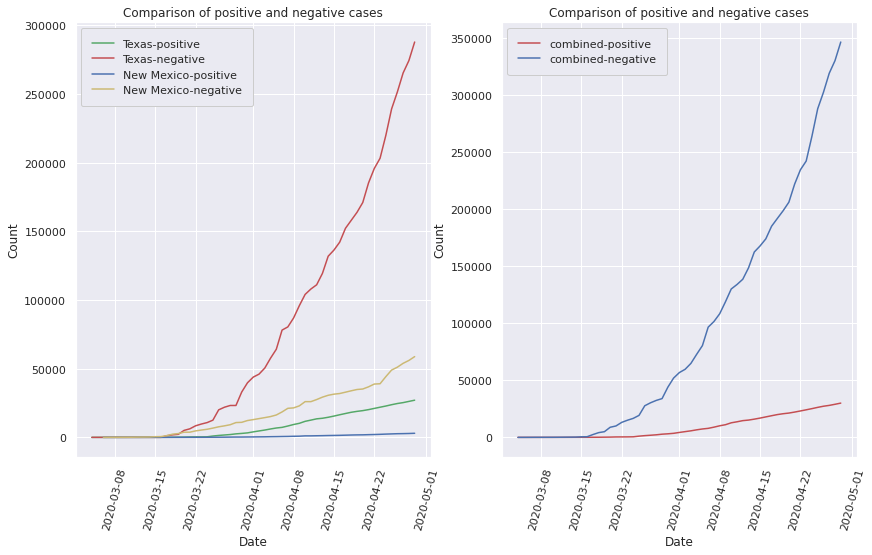

In [0]:
#Plot 1:Comparison of the number of postive and negative cases(daily) [States separated and combined both]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 8))

axes[0].plot(data_TX["date"],data_TX["positive"],'-g', label='Texas-positive');
axes[0].plot(data_TX["date"],data_TX["negative"],'-r', label='Texas-negative');
axes[0].plot(data_NM["date"],data_NM["positive"],'-b', label='New Mexico-positive');
axes[0].plot(data_NM["date"],data_NM["negative"],'-y', label='New Mexico-negative');

axes[0].set(title = "Comparison of positive and negative cases",xlabel = "Date",ylabel = "Count");
axes[0].tick_params(axis='x', labelrotation=75)
axes[0].legend(fancybox=True, framealpha=1, borderpad=1)


axes[1].plot(comb_data["date"],comb_data["positive"],'-r', label='combined-positive');
axes[1].plot(comb_data["date"],comb_data["negative"],'-b', label='combined-negative');
axes[1].set(title = "Comparison of positive and negative cases",xlabel = "Date",ylabel = "Count");
axes[1].legend(fancybox=True, framealpha=1, borderpad=1)
axes[1].tick_params(axis='x', labelrotation=75)


<b>Idea:To compare  the number of postive and negative cases(daily) [States separated and combined both]</b><br>
As we can see from the above plot, the increase in negative cases has been really high for both the states, Also, the growth of positive cases is much more lesser than the growth of negative cases which summarizes for us that out of all tested individuals, the number of positive cases is quite less for both the states.<br>
For an overview, we can refer to the olot on the right which clearly compares the growth rates of both negative and positive cases.

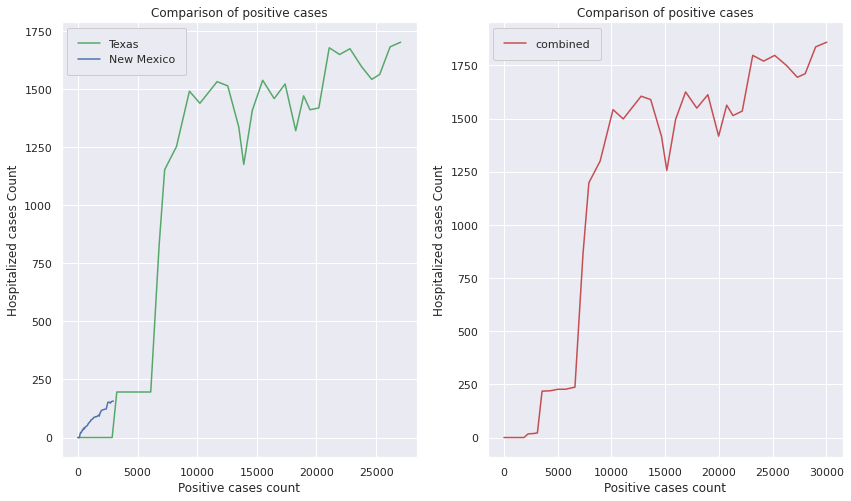

In [0]:
#Plot 2:Comparison of how many patients out of positive cases were hospitalized [States separated and combined both]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 8))

axes[0].plot(data_TX["positive"],data_TX["hospitalizedCurrently"],'-g', label='Texas');
axes[0].plot(data_NM["positive"],data_NM["hospitalizedCurrently"],'-b', label='New Mexico');
axes[0].legend(fancybox=True, framealpha=1, borderpad=1)
axes[0].set(title = "Comparison of positive cases",xlabel = "Positive cases count",ylabel = "Hospitalized cases Count");

axes[1].plot(comb_data["positive"],comb_data["hospitalizedCurrently"],'-r', label='combined');
axes[1].legend(fancybox=True, framealpha=1, borderpad=1)
axes[1].set(title = "Comparison of positive cases",xlabel = "Positive cases count",ylabel = "Hospitalized cases Count");

<b>Idea: To compare how many patients out of positive cases were hospitalized [States separated and combined both]</b><br>
From the curve of the above plot we can see that as the number of positive cases kept on increasing there was a simultaneous increase in patients who were hospitalized which also led to the high number of recoveries and low death rate for both the states.<br>
The plot on the right summaries the combined information for us.

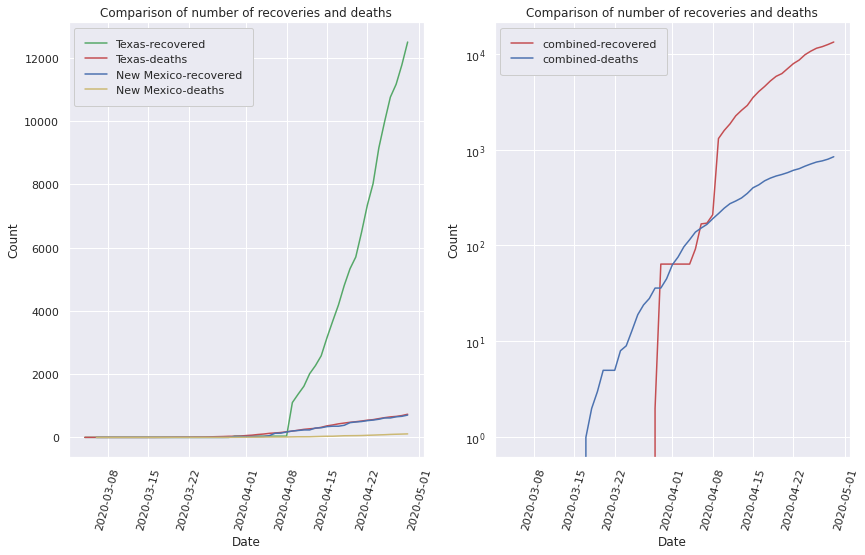

In [0]:
#Plot 3:Comparison of the number of recoveries and deaths[States separated and combined both]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 8))
axes[1].set_yscale('log')
axes[0].plot(data_TX["date"],data_TX["recovered"],'-g', label='Texas-recovered');
axes[0].plot(data_TX["date"],data_TX["death"],'-r', label='Texas-deaths');

axes[0].tick_params(axis='x', labelrotation=75)

axes[0].plot(data_NM["date"],data_NM["recovered"],'-b', label='New Mexico-recovered');
axes[0].plot(data_NM["date"],data_NM["death"],'-y', label='New Mexico-deaths');
axes[0].set(title = "Comparison of number of recoveries and deaths",xlabel = "Date",ylabel = "Count");
axes[0].legend(fancybox=True, framealpha=1, borderpad=1)

axes[1].plot(comb_data["date"],comb_data["recovered"],'-r', label='combined-recovered');
axes[1].plot(comb_data["date"],comb_data["death"],'-b', label='combined-deaths');
axes[1].set(title = "Comparison of number of recoveries and deaths",xlabel = "Date",ylabel = "Count");
axes[1].legend(fancybox=True, framealpha=1, borderpad=1)
axes[1].tick_params(axis='x', labelrotation=75)


<b>Idea:To compare the number of recoveries and deaths[States separated and combined both]</b><br>
From the above graph we can see that the recovery rate for Texas has been really great while the death rate has had a really slow growth. For New Mexico, the recovery rate has been okay in comparison to the death rate which looks like a good sign.<br>
The plot on the right is on a logarithmic scale and displays the combined stats for the combined region.

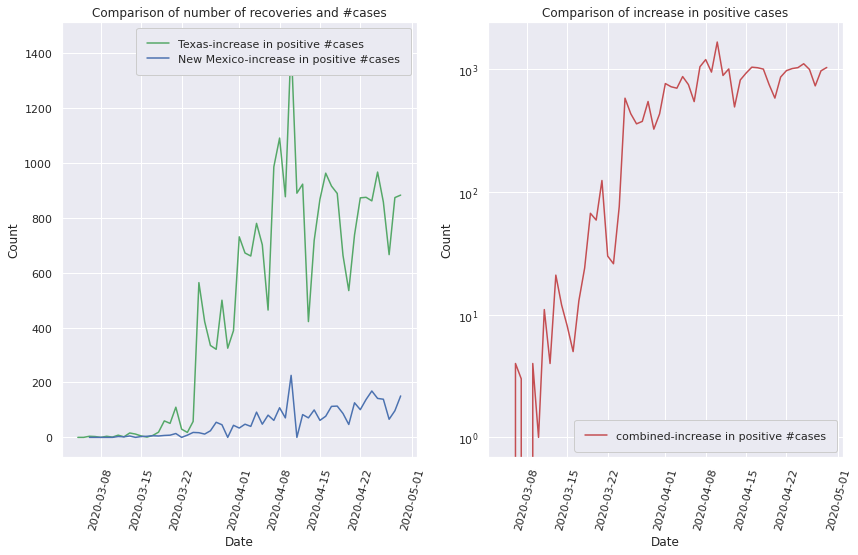

In [0]:
#Plot 4:Comparison of increase in number of positive cases[States separated and combined both]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 8))

axes[0].plot(data_TX["date"],data_TX["positiveIncrease"],'-g', label='Texas-increase in positive #cases');
axes[0].tick_params(axis='x', labelrotation=75)

axes[0].plot(data_NM["date"],data_NM["positiveIncrease"],'-b', label='New Mexico-increase in positive #cases');
axes[0].set(title = "Comparison of number of recoveries and #cases",xlabel = "Date",ylabel = "Count");
axes[0].legend(fancybox=True, framealpha=1, borderpad=1)

axes[1].plot(comb_data["date"],comb_data["positiveIncrease"],'-r', label='combined-increase in positive #cases');
axes[1].set(title = "Comparison of increase in positive cases",xlabel = "Date",ylabel = "Count");
axes[1].legend(fancybox=True, framealpha=1, borderpad=1)
axes[1].tick_params(axis='x', labelrotation=75)
axes[1].set_yscale('log')


<b>Idea:To compare increase in number of positive cases[States separated and combined both]</b><br>
From the above line chart, we can clearly see that the count of positive cases was much more in Texas than in New Mexico and the number fluctuates quite a lot for both the states. We also noticed a sudden spike around April first week which relates to the news headline "Sixty residents and nine staff members at a San Antonio nursing home have been infected with COVID-19". Similarly, in the week around March 15 there is also a sudden spike relating to the news "Dallas County Judge Clay Jenkins announced five additional positive cases with one of the cases being the first instance of community spread in the North Texas area.". Similarly for New Mexico, we see a spike around April 4 as "51 new cases are reported with 23 in Bernalillo, 9 in San Juan, 6 in Santa Fe, 4 in Cibola, 3 in Torrance, 2 in Sandoval, and the first reported cases in Lincoln and Los Alamos counties and one new case in McKinley and Rio Arriba counties bringing the statewide total to 543."<br>
Apart from that we can also see that the increase on the logarithmic scale keeps up with the general distribution of increase in covid positive numbers.


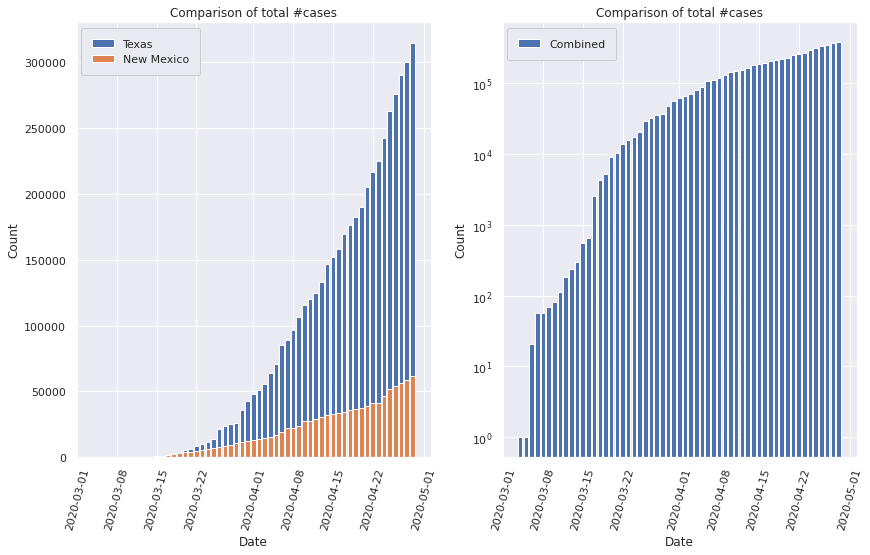

In [0]:
#Plot 5:Comparison of total number of cases[States separated and combined both]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 8))

axes[0].bar(data_TX["date"],data_TX["total"],label='Texas');

axes[0].bar(data_NM["date"],data_NM["total"],label='New Mexico');
axes[0].tick_params(axis='x', labelrotation=75)
axes[0].set(title = "Comparison of total #cases",xlabel = "Date",ylabel = "Count");
axes[0].legend(fancybox=True, framealpha=1, borderpad=1)

axes[1].bar(comb_data["date"],comb_data["total"], label='Combined');
axes[1].set(title = "Comparison of total #cases",xlabel = "Date",ylabel = "Count");
axes[1].legend(fancybox=True, framealpha=1, borderpad=1)
axes[1].tick_params(axis='x', labelrotation=75)
axes[1].set_yscale('log')


<b>Idea: To compare the total number of cases of the two states[States separated and combined both]</b><br>
A histogram seemed like a good idea here to see the growth rate and as we can see the number of cases increased exponentially day by day. The plot on the right is on a logarithmic scale which confirms the belief that the growth in the number of corona virus cases increases exponentially.

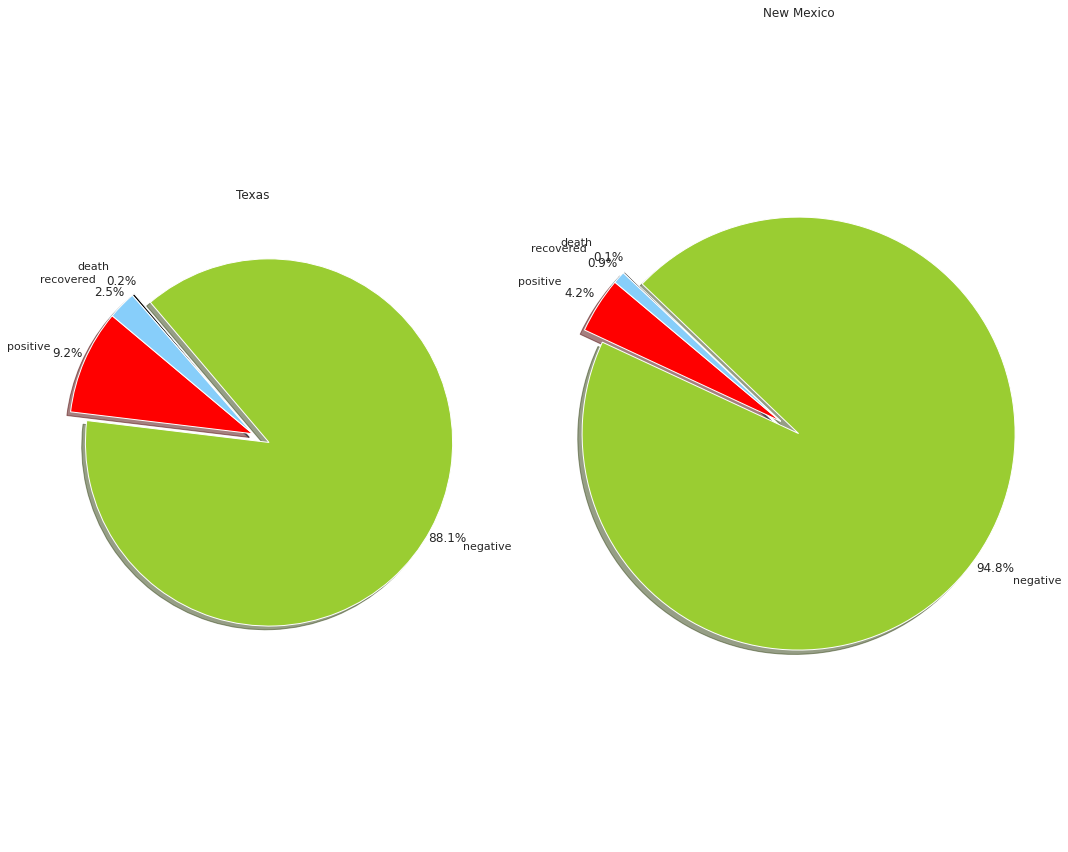

In [0]:
#Plot 6:Comparison of final stats till the latest data available for Texas and New Mexico
data_TX_red=data_TX[['positive','negative','death','recovered']]
data_TX_red=data_TX_red.astype(int)
TX_sum=data_TX_red.sum(axis=0)

data_NM_red=data_NM[['positive','negative','death','recovered']]
data_NM_red=data_NM_red.astype(int)
NM_sum=data_NM_red.sum(axis=0)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 12))

labels = 'positive','negative','death','recovered'
colors = ['red', 'yellowgreen', 'black', 'lightskyblue']
explode = (0, 0.1, 0, 0) 
axes[0].pie(TX_sum,labels=labels, colors=colors,explode = explode,autopct='%1.1f%%',shadow=True,startangle=140,pctdistance=1.1, labeldistance=1.2)
axes[0].set(title='Texas')
axes[1].pie(NM_sum,labels=labels, colors=colors,explode = explode,autopct='%1.1f%%',shadow=True,startangle=140,pctdistance=1.1, labeldistance=1.2)
axes[1].set(title='New Mexico')

#plt.title('Comparison of final stats till the latest data available for Texas and New Mexico',loc='left')
plt.axis('equal')
plt.tight_layout()
plt.show()

<b>Idea: To compare the final statistics of the two states till the latest data available.</b><br>
A pie chart makes it easy to compare and we can see from the above plot that a very large percentage of tests carried out were negative for both the states and out of the percentage of positive cases the death percentage is extremely small which is a good thing.

#Required Inferences

In [0]:
#Required cleanup for this inference
df = pd.read_csv('daily.csv')
#Read data from texas and new mexico
df = df[df["state"].isin(["TX", "NM"])]
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
df = df.sort_values('date')
df.fillna(0, inplace=True)

#Extract the data for the two relevant weeks
week_one = df.iloc[len(df) - 14:len(df) - 7]
week_n = df.iloc[len(df) - 7:, :]

##Required Inference 1
Time Series

In [0]:
# Functions to compute timeseries p: p value for AR(p); data: Data; num: the number of days to predict
def AR(p, data, num =7):
    #Create Training data for the beta values
    y = []
    x = []
    #All but the last few days determined by the variable num
    for i in range(p, len(data)-num):
        y.append(data[i])
        temp = []
        for j in range(1, p + 1):
            temp.append(data[i-j])
        x.append(temp)

    real_values = data[len(data)-num:]
    x = np.array(x)
    y_orig = y
    y = np.array(y)
    #X is of shape(n, p)
    X = x.reshape(len(x), p)
    X = np.c_[ X, np.ones(len(X)) ]
    #Y is of shape (n, 1)
    Y = y.reshape(len(y), 1)
    #Computing the beta values. Similar to the linear regression.
    b = inv(X.T.dot(X)).dot(X.T).dot(Y) # The beta values
    #Predicting the next num values
    ans = []
    #Predict the values for num number of days
    for i in range(0, num):
        pred = 0
        for j in range(1, p+1):
            pred = pred + y_orig[len(y_orig)-j] * b[j-1]
        pred = pred + b[p]
        ans.append(pred[0])
        y_orig.append(pred)
        
    #Printing the real and the computed values. Can comment out
    print("Real Data", real_values)
    print("Predicted Values", ans)
    #Computing MAPE
    sums = 0
    for i in range(0, len(ans)):
        diff = (abs(real_values[i]-ans[i])/real_values[i]) * 100
        sums = sums + diff
    sums = sums/len(real_values)
    #Computing MSE
    MSE = np.sum(np.square(real_values - ans))/len(real_values)
    #Returning MAPE% and MSE
    return {"MAPE %": sums, "MSE": MSE}

#Function to predict data using EWMA; Arguments self explanatory
def EWMA(data, alpha, num=7):
    #Initialize and find the last predicted value
    y_last_predicted = data[0]
    for i in range(1, len(data)-num):
        y_last_predicted = y_last_predicted * (1 - alpha) + data[i] * alpha
    ans = []
    #Use the num variable to get the real values for the final computation
    real_values = data[len(data)-num: ]
    #Compute the values
    for i in range(len(data)-num, len(data)):
        x = data[i] * alpha + y_last_predicted * (1 - alpha)
        ans.append(x)
    #Print the data
    print("Real Data", real_values)
    print("Predicted Values", ans)
    sums = 0
    #Calculate MAPE
    for i in range(0, len(ans)):
        diff = (abs(real_values[i]-ans[i])/real_values[i]) * 100
        sums = sums + diff
    sums = sums/len(real_values)
    #Calculate MSE
    MSE = np.sum(np.square(real_values - ans))/len(real_values)
    return {"MAPE %": sums, "MSE": MSE}

In [0]:
deaths = df["death"].to_numpy()
print(AR(3, deaths))
print(AR(5, deaths))
print(EWMA(deaths, 0.5))
print(EWMA(deaths, 0.8))

Real Data [ 93. 663.  99. 690. 104. 732. 110.]
Predicted Values [187.19813837614174, 472.2577140470745, 304.28113120679143, 364.1020729601822, 341.7066191961495, 324.69127389170734, 334.9096665753532]
{'MAPE %': 124.75925953891621, 'MSE': 66656.41484216123}
Real Data [ 93. 663.  99. 690. 104. 732. 110.]
Predicted Values [170.41304491950748, 540.3997417586422, 267.3193676465436, 511.6652243293061, 323.14829321464885, 474.8411118091806, 375.53017258410944]
{'MAPE %': 112.11976197992252, 'MSE': 37974.46361856933}
Real Data [ 93. 663.  99. 690. 104. 732. 110.]
Predicted Values [275.16120950963773, 560.1612095096377, 278.16120950963773, 573.6612095096377, 280.66120950963773, 594.6612095096377, 283.66120950963773]
{'MAPE %': 107.95964504695168, 'MSE': 24231.61689319507}
Real Data [ 93. 663.  99. 690. 104. 732. 110.]
Predicted Values [185.0366675195392, 641.0366675195392, 189.83666751953922, 662.6366675195392, 193.83666751953922, 696.2366675195392, 198.63666751953923]
{'MAPE %': 52.8346699026

##Required Inference 2
Walds, Z and T test

In [0]:
#Sample mean calculation
def calc_sample_mean(data):
    n = len(data)
    sum = 0
    for i in data:
        sum += i
    return sum / n
#As described in the class
def calc_normal_mle(data):
    u_hat = calc_sample_mean(data)
    sigma_hat = 0
    for i in data:
        sigma_hat += (i - u_hat) * (i - u_hat)
    sigma_hat = sigma_hat / len(data)
    return round(u_hat, 3), round(sigma_hat, 3)

#One tailed test
def walds_test(X, u, H0):
    #MLE
    mu_x_hat, var_x_hat = calc_normal_mle(X)
    delta_hat = mu_x_hat - u
    se_hat = np.sqrt(var_x_hat/len(X))
    #Calculating W
    W = np.absolute(delta_hat/se_hat)
    if W > 1.96:
        print("walds_test: Rejecting the null hypothesis: ", H0, " With value W=",W)
    else:
        print("walds_test: Accepting the null hypothesis: ", H0, " With value W=",W)
#Two tailed test
def walds_two_tail_test(X, Y, H0):
    #Calculating Mean
    mu_x_hat = calc_sample_mean(X)
    mu_y_hat = calc_sample_mean(Y)
    delta_hat = mu_x_hat - mu_y_hat
    var_x = np.sum(np.square(X-mu_x_hat))/len(X)
    var_y = np.sum(np.square(Y-mu_y_hat))/len(Y)
    #SE hat
    se_hat = np.sqrt((var_x + var_y)/len(X))
    #Calculate W
    W = np.absolute(delta_hat/se_hat)
    if W > 1.96:
        print("walds_two_tail_test: Rejecting the null hypothesis: ", H0, " With value W=",W)
    else:
        print("walds_two_tail_test: Accepting the null hypothesis: ", H0, " With value W=",W)
#Z Test
def z_test(X, sigma, u, H0):
    x_bar = np.mean(X)
    n = len(X)
    #Calculate Z
    Z = (x_bar - u)/(sigma/np.sqrt(n))
    if Z > 1.96:
        print("z_test: Rejecting the null hypothesis: ", H0, " With value Z=",Z)
    else:
        print("z_test: Accepting the null hypothesis: ", H0, " With value Z=",Z)

def t_test(X, u, H0, alpha = 0.05):
    x_bar = np.mean(X)
    n = len(X) - 1
    sigma = np.std(X)
    #Calculate T
    T = np.abs((x_bar - u)/(sigma/np.sqrt(n)))
    val = stats.t.ppf(1-alpha, n-1)
    if T > val:
        print("t_test: Rejecting the null hypothesis: ", H0, " With value T=",T)
    else:
        print("t_test: Accepting the null hypothesis: ", H0, " With value T=",T)
#Two Sample tests
def t_test_two_tailed_paired(X, Y, H0):
    D = X-Y
    n = len(D)
    d_bar = np.mean(D)
    sigma = np.std(D)
    se = sigma/(np.sqrt(n))
    T = np.abs(d_bar/se)
    alpha = 0.05/2
    val = stats.t.ppf(1-alpha, n-1)
    if T > val:
        print("t_test_two_tailed_paired: Rejecting the null hypothesis: ", H0, " With value T=",T)
    else:
        print("t_test_two_tailed_paired: Accepting the null hypothesis: ", H0, " With value T=",T)

#Two sample unpaired test
def t_test_two_tailed_unpaired(X, Y, H0):
    D = X-Y
    n = len(D)
    s_x = np.std(X)
    s_y = np.std(Y)
    #Calculate pooled std
    pooled_std = np.sqrt((np.square(s_x) / n) + (np.square(s_y) / n))
    d_bar = np.mean(D)
    #Calculate T
    T = np.abs(d_bar/pooled_std)
    alpha = 0.05/2
    val = stats.t.ppf(1-alpha, n-1)
    if T > val:
        print("t_test_two_tailed_unpaired: Rejecting the null hypothesis: ", H0, " With value T=",T)
    else:
        print("t_test_two_tailed_unpaired: Accepting the null hypothesis: ", H0, " With value T=",T)


In [0]:
#@Warning the column values are imputed with 0 inplace
def inference_two(column, H0):
    df[column].fillna(0, inplace=True)
    mu = week_one[column].mean()
    c_array_wn = week_n[column].to_numpy()
    c_array_w1 = week_one[column].to_numpy()
    sigma = df[column].std()
    walds_test(c_array_wn, mu, H0)
    walds_two_tail_test(c_array_w1, c_array_wn, H0)
    z_test(c_array_wn, sigma, mu, H0)
    t_test(c_array_wn, mu, H0)
    t_test_two_tailed_paired(c_array_w1, c_array_wn, H0)
    t_test_two_tailed_unpaired(c_array_w1, c_array_wn, H0)

In [0]:
#On the Death column
inference_two("death", "Mean of Covid 19 deaths in second last and last week of dataset is the same")

walds_test: Accepting the null hypothesis:  Mean of Covid 19 deaths in second last and last week of dataset is the same  With value W= 0.21445329512670405
walds_two_tail_test: Accepting the null hypothesis:  Mean of Covid 19 deaths in second last and last week of dataset is the same  With value W= 0.15997737074729546
z_test: Accepting the null hypothesis:  Mean of Covid 19 deaths in second last and last week of dataset is the same  With value Z= -0.33500965643443403
t_test: Accepting the null hypothesis:  Mean of Covid 19 deaths in second last and last week of dataset is the same  With value T= 0.19854398185384695
t_test_two_tailed_paired: Accepting the null hypothesis:  Mean of Covid 19 deaths in second last and last week of dataset is the same  With value T= 0.13185244332785478
t_test_two_tailed_unpaired: Accepting the null hypothesis:  Mean of Covid 19 deaths in second last and last week of dataset is the same  With value T= 0.15997737074729523


In [0]:
#Running on the total column
inference_two("total", "Total Covid 19 cases in second last and last week of dataset is the same")

walds_test: Accepting the null hypothesis:  Total Covid 19 cases in second last and last week of dataset is the same  With value W= 0.028661866518321706
walds_two_tail_test: Accepting the null hypothesis:  Total Covid 19 cases in second last and last week of dataset is the same  With value W= 0.021860515114876786
z_test: Accepting the null hypothesis:  Total Covid 19 cases in second last and last week of dataset is the same  With value Z= -0.04509816638243091
t_test: Accepting the null hypothesis:  Total Covid 19 cases in second last and last week of dataset is the same  With value T= 0.026535729228428343
t_test_two_tailed_paired: Accepting the null hypothesis:  Total Covid 19 cases in second last and last week of dataset is the same  With value T= 0.01799005406982224
t_test_two_tailed_unpaired: Accepting the null hypothesis:  Total Covid 19 cases in second last and last week of dataset is the same  With value T= 0.021860515114876578


### Conclusion
####Applicability 
Below we check the applicability of the tests. 
###Walds test
Since the walds test requires the estimator to be asymptotically normal this test is not applicable in this current data. 
###Z-Test
In Z test we know that either the number of datapoints needs to be very high or the points should follow a normal distribution. In our case none of the above is true hence Z test is not applicable as well.
###T-Test
T-test is usually used when we have small number of datapoints. But the test still requires the datapoints to be in normal distribution. Hence if we can't prove the values are normally distributed this test won't be applicable as well. 

Now Since the number of deaths per day or the number of total cases are not normally distributed we can say that the above tests are not applicable in the current state. 

##Required Inference 3
KS Test and P-Test

In [0]:
#Helper functions
#Calculating the MME based on class derivations.
def calculate_poission_mme(data):
    return  round(calc_sample_mean(data), 3)

def calc_geometric_mme(data):
    return round(1 / calc_sample_mean(data), 3)

def calc_square_sum(data):
    square_sum = 0
    for i in data:
        square_sum += i * i
    return square_sum

def calc_second_moment(data):
    return calc_square_sum(data) / len(data)

def calc_binomeal_mme(data):
    u_hat = calc_sample_mean(data)
    sub = 0
    for d in data:
        sub = sub + pow(d - u_hat, 2)
    sub = sub/np.sum(data)
    p = 1 - sub
    n = u_hat/p
    return n, p

In [0]:
#Ks Two Sample test
def ks_test_two_sample(X, Y, c, H0):
    if len(Y) < len(X):
        ks_test_two_sample(Y, X)
        return
    #X is always the smaller set or equal in this particular case.
    counter_x = Counter(X)
    counter_y = Counter(Y)
    #Get number of change points
    change_points = len(Y)
    #Calculate the increments
    inc = (1/change_points)
    sorted_y = sorted(Y)
    prev = 0
    max_diff = -sys.maxsize - 1
    #Run through all the unique values in x
    for val in sorted(counter_x.keys()):
        ch = 0
        #Find all the values smaller than val in Y and add to ch
        for v in sorted(counter_y.keys()):
            if v > val:
                break
            ch = ch + inc * counter_y[v]
        v1 = ch
        v2 = prev
        v3 = prev + inc * counter_x[val]
        prev = v3
        #Check and update max difference
        max_diffn = max(max_diff, max(abs(v1-v2), abs(v1-v3)))
        if max_diffn != max_diff:
            max_diff = max_diffn
    if max_diff > c:
         print("KS_test: Rejecting the null hypothesis: ", H0, " With value D=",max_diff)
    else:
        print("KS_test: Accepting the null hypothesis: ", H0, " With value D=",max_diff)

#The cdf data contains the values for the proposed distribution. (ex: binomial)
def ks_test(data, cdf_data, c, H0):
    change_points = len(data)
    dictionary = Counter(data)
    unique_values = sorted(dictionary.keys())
    F_Y_x = []
    F_hat_X_x_mi = []
    F_hat_X_x_ma = []
    prev = 0
    #Calculate the increments
    inc = (1/change_points)
    max_diff = -sys.maxsize - 1
    for val in unique_values:
        v1 = cdf_data[val]#distribution.cdf(val, lambda_hat)
        v2 = prev
        #The number of times this value is seen is the dataset times the increment
        prev = prev + inc * dictionary[val]
        v3 = prev
        F_Y_x.append(v1)
        F_hat_X_x_mi.append(v2)
        F_hat_X_x_ma.append(v3)
        #Check and update the max difference
        max_diff = max(max_diff, max(abs(v1-v2), abs(v1-v3)))
    if max_diff > c:
         print("KS_test: Rejecting the null hypothesis: ", H0, " With value D=",max_diff)
    else:
        print("KS_test: Accepting the null hypothesis: ", H0, " With value D=",max_diff)

def permutation_test(X, Y, p_count, p_threshold):
    x_bar = np.mean(X)
    y_bar = np.mean(Y)
    #Observed statistic
    t_obs = abs(x_bar - y_bar)
    C = np.concatenate((X, Y))
    count = 0
    #Run the test p_count times
    for i in range(p_count):
        p = np.random.permutation(C)
        mid = int(len(C) / 2)
        t_i = abs(np.mean(p[:mid]) - np.mean(p[mid:]))
        if t_i > t_obs:
            count += 1
    #Calculating the p value
    p_value = count / p_count
    if p_value <= p_threshold:
        print("P-Test: Rejecting Null Hypothesis, X and Y don't come from same distribution with p value", p_value)
    else:
        print("P-Test: Accepting Null Hypothesis, X and Y come from same distribution with p value", p_value)


In [0]:
###Deaths
#Poisson test 1 sample ks
lambda_hat = calculate_poission_mme(week_one["death"].to_numpy())
death2 = week_n["death"].to_numpy()
val_to_cdf_dic = {}
for d in death2:
    val_to_cdf_dic[d] = stats.poisson.cdf(d, lambda_hat)

ks_test(death2, val_to_cdf_dic, 0.05, "Deaths belong to poisson distribution")

#Geometric Distribution
geometric_mean = calc_geometric_mme(week_one["death"].to_numpy())
val_to_cdf_dic = {}
for d in death2:
    val_to_cdf_dic[d] = stats.geom.cdf(d, geometric_mean)
ks_test(death2, val_to_cdf_dic, 0.05, "Deaths belong to Geometric distribution")

#Binomial Distribution
n, p = calc_binomeal_mme(week_one["death"].to_numpy())
val_to_cdf_dic = {}
for d in death2:
    val_to_cdf_dic[d] = stats.binom.cdf(d, n, p)
ks_test(death2, val_to_cdf_dic, 0.05, "Deaths belong to Binomial distribution")

#KS Two sample test
ks_test_two_sample(week_n["death"].to_numpy(), week_one["death"].to_numpy(), 0.05, "Second last and last week are from same distribution")

#P-Test
X, Y = week_one["death"], week_n["death"]
permutation_test(X.to_numpy(), Y.to_numpy(), 50000, 0.05)

KS_test: Rejecting the null hypothesis:  Deaths belong to poisson distribution  With value D= 0.5714285714285714
KS_test: Rejecting the null hypothesis:  Deaths belong to Geometric distribution  With value D= 0.2921476856603765
KS_test: Rejecting the null hypothesis:  Deaths belong to Binomial distribution  With value D= 1.0
KS_test: Rejecting the null hypothesis:  Second last and last week are from same distribution  With value D= 0.42857142857142855
P-Test: Accepting Null Hypothesis, X and Y come from same distribution with p value 0.99954


In [0]:
#Total
lambda_hat = calculate_poission_mme(week_one["total"].to_numpy())
totals = week_n["total"].to_numpy()
val_to_cdf_dic = {}
for d in totals:
    val_to_cdf_dic[d] = stats.poisson.cdf(d, lambda_hat)

ks_test(totals, val_to_cdf_dic, 0.05, "total belong to poisson distribution")

#Geometric Distribution
geometric_mean = calc_geometric_mme(week_one["total"].to_numpy())
val_to_cdf_dic = {}
for d in totals:
    val_to_cdf_dic[d] = stats.geom.cdf(d, geometric_mean)
ks_test(totals, val_to_cdf_dic, 0.05, "total belong to Geometric distribution")

#Binomial Distribution
n, p = calc_binomeal_mme(week_one["total"].to_numpy())
val_to_cdf_dic = {}
for d in totals:
    val_to_cdf_dic[d] = stats.binom.cdf(d, n, p)
ks_test(totals, val_to_cdf_dic, 0.05, "total belong to Binomial distribution")

#KS Two sample test
ks_test_two_sample(week_n["total"].to_numpy(), week_one["total"].to_numpy(), 0.05, "Second last and last week are from same distribution")

#P-Test
X, Y = week_one["total"], week_n["total"]
permutation_test(X.to_numpy(), Y.to_numpy(), 50000, 0.05)

KS_test: Rejecting the null hypothesis:  total belong to poisson distribution  With value D= 0.5714285714285714
KS_test: Rejecting the null hypothesis:  total belong to Geometric distribution  With value D= 0.9999999999999998
KS_test: Rejecting the null hypothesis:  total belong to Binomial distribution  With value D= 1.0
KS_test: Rejecting the null hypothesis:  Second last and last week are from same distribution  With value D= 0.42857142857142855
P-Test: Accepting Null Hypothesis, X and Y come from same distribution with p value 0.99938


##Required Inference 4
Correlation


**Note:**

We are using the financial stock data of TripAdvisor as our X dataset(which is an online travel site for booking tickets to travel around the world.) We sense our covid dataset and this dataset could be related with people travelling all around the globe - they might potentially be carrying and spreading the virus.

In this task, let us calculate the pearson correlation to find out if some specific columns between these two are correlated or not.

In [0]:
tx_nm_data =  pd.read_csv("tx_nm_data2.csv")
#Reading in data that has dates between march april for getting 1-1.5 month data.
tx_nm_data = tx_nm_data[tx_nm_data['date'].astype(str).str.contains("202003|202004", na=False)]
# tx_nm_data['date'].unique()
#Reading in X dataset - stock data of TripAdvisor
trip_stock_data = pd.read_csv("TRIP.csv")
trip_stock_data.rename(columns={'Date':'date'}, inplace=True)
#We need to format time of datasets to match with the date time format of all.
df = pd.DataFrame({'year': tx_nm_data.date.astype(str).str.slice(0,4),
                   'month': tx_nm_data.date.astype(str).str.slice(4,6),
                   'day': tx_nm_data.date.astype(str).str.slice(6,8)})
tx_nm_data['date'] = pd.Series(pd.to_datetime(df))
tx_nm_data['date'] = pd.to_datetime(tx_nm_data['date'], utc = True)
# nm_data['date'] = pd.to_datetime(nm_data['date'], utc = True)
trip_stock_data['date'] = pd.to_datetime(trip_stock_data['date'], utc = True)
#Merging data on date as common column
tx_nm_stock = pd.merge(tx_nm_data, trip_stock_data, on='date')
# nm_stock = pd.merge(nm_data,trip_stock_data,on='date')
#Keeping only the date part, time is 00:00:00 anyway
tx_nm_stock['date'] = tx_nm_stock['date'].dt.date
tx_nm_stock.to_csv("tx_nm_stock.csv")


**From the X dataset, we are using the column "Stock Volatility" as its the most relevant column which gives us the stock price multiplied by the number of stocks bought/sold on a particular date which may or may not be impacted by our COVID data** (we'll see that further!)

In [0]:
#Calculating pearson correlation between #deaths and stock volatility of tripadvisor
mean_x = tx_nm_stock['death'].mean()
mean_x
mean_y = tx_nm_stock['Volume'].mean()
mean_y

numerator = 0
temp = pd.DataFrame()

temp['x'] = tx_nm_stock['death'] - mean_x
temp['y'] = tx_nm_stock['Volume'] - mean_y

numerator = (temp['x'] * temp['y']).sum()
numerator

temp['xsq'] = temp['x'] * temp['x']
temp['ysq'] = temp['y'] * temp['y']

sumofxsquares = temp['xsq'].sum()
sumofysquares = temp['ysq'].sum()

denominator = np.sqrt(sumofxsquares) * np.sqrt(sumofysquares)
denominator

pearson_correlation_dv = np.divide(numerator,denominator)
pearson_correlation_dv

-0.45852727730530113

In [0]:
#Calculating correlation between #positive cases and stock volatility of trip advisor

#Calculating mean of both X and Y => Xbar, Ybar
mean_x = tx_nm_stock['positive'].mean()
# mean_x
mean_y = tx_nm_stock['Volume'].mean()
# mean_y

numerator = 0
temp = pd.DataFrame()

#Calculation of X-Xbar, Y - Ybar
temp['x'] = tx_nm_stock['positive'] - mean_x
temp['y'] = tx_nm_stock['Volume'] - mean_y

#Sum of products of (X-Xbar)(Y-Ybar)
numerator = (temp['x'] * temp['y']).sum()
# numerator

temp['xsq'] = temp['x'] * temp['x']
temp['ysq'] = temp['y'] * temp['y']

sumofxsquares = temp['xsq'].sum()
sumofysquares = temp['ysq'].sum()

denominator = np.sqrt(sumofxsquares) * np.sqrt(sumofysquares)
# denominator

pearson_correlation_cv = np.divide(numerator,denominator)
pearson_correlation_cv

-0.4915368676458895

In [0]:
print("The pearson correlation coeffecient between the number of deaths and stock volatility is ",pearson_correlation_dv)
if pearson_correlation_dv > 0.5:
  print("Positive Linear Correlation")
elif pearson_correlation_dv < -0.5:
  print("Negative linear correlation")
elif pearson_correlation_dv <= 0.5:
  print("No linear correlation")

The pearson correlation coeffecient between the number of deaths and stock volatility is  -0.45852727730530113
No linear correlation


In [0]:
print("The pearson correlation coeffecient between the number of positive cases and stock volatility is ",pearson_correlation_cv)
if pearson_correlation_cv > 0.5:
  print("Positive Linear Correlation")
elif pearson_correlation_cv < -0.5:
  print("Negative linear correlation")
elif pearson_correlation_cv <= 0.5:
  print("No linear correlation")

The pearson correlation coeffecient between the number of positive cases and stock volatility is  -0.4915368676458895
No linear correlation


**There is no linear correlation observed between the #deaths or stock volatility or even in #positive_cases or stock volatility**

But we can surely see that the value is closer to a negative correlation than to a positive one.

##Required Inference 5
Prior Posterior.

In [0]:
i=range(7,math.ceil(comb_data.shape[0]/7)*7,7)
week=np.split(comb_data,i)

In [0]:
week

[        date  positive  ...  positiveIncrease  totalTestResultsIncrease
 0 2020-03-04       1.0  ...               0.0                       0.0
 1 2020-03-05       1.0  ...               0.0                       0.0
 2 2020-03-06       5.0  ...               4.0                       4.0
 3 2020-03-07       8.0  ...               3.0                      35.0
 4 2020-03-08       8.0  ...               0.0                       0.0
 5 2020-03-09      12.0  ...               4.0                      13.0
 6 2020-03-10      13.0  ...               1.0                      13.0
 
 [7 rows x 22 columns],
          date  positive  ...  positiveIncrease  totalTestResultsIncrease
 7  2020-03-11      24.0  ...              11.0                      29.0
 8  2020-03-12      28.0  ...               4.0                      72.0
 9  2020-03-13      49.0  ...              21.0                      56.0
 10 2020-03-14      61.0  ...              12.0                      59.0
 11 2020-03-15      

MAP 1 = 842.0
MAP 2 = 719.0909090909091
MAP 3 = 614.3030303030303
MAP 4 = 506.1212121212121
MAP 5 = 409.22222222222223


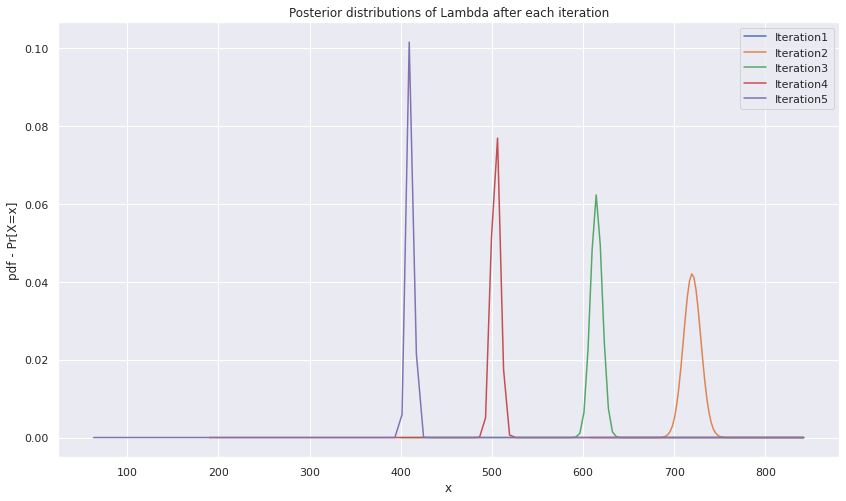

In [0]:
#After solving, we found the distribution to be gamma distribution with alpha = n*mean(X) and beta = n+(1/beta_prior)
lambda_m=week[len(week)-1].death.mean()
beta_pri=lambda_m

temp = []
plt.figure(figsize=(14,8))
for i in range(5):
    temp.extend(week[len(week)-1-i].death)
    max_temp = max(temp)
    min_temp = min(temp)
    mean_ = np.mean(temp)
    range_ = np.linspace(min_temp, max_temp, 100)
    alpha = (len(temp)*mean_)+1
    beta = len(temp)+(1/beta_pri)
    g_pdf = gamma.pdf(range_, a = alpha, scale = float(1)/beta)
    print("MAP " + str(i+1)+ " = " + str(range_[np.argmax(g_pdf)]))
    plt.plot(range_, g_pdf, label="Iteration"+str(i+1))


plt.legend()
plt.xlabel("x")
plt.ylabel("pdf - Pr[X=x]")
plt.title('Posterior distributions of Lambda after each iteration')
plt.show()

I have kept iteration values 5 as april data is getting divided into 5 parts and there is only one day (April29th) in the last part and to get the inference for the ntire month of April we kept the iteration values as 5. Also,I started my calculations from the last week to the first week of April. 

#Creative Inference

#Creative Inference 1

**For the new creative inference - We choose the chi square test to show whether or not the X dataset and the COVID dataset had an impact on each other**

The hypothesis we present is listed down below.

**Before actually beginning with our chi-square test, we'd like to see the trends in the data by plotting a few graphs**

In [0]:
tx_nm_stock =  pd.read_csv("tx_nm_stock.csv")
trip_stock_data = pd.read_csv("TRIP.csv")

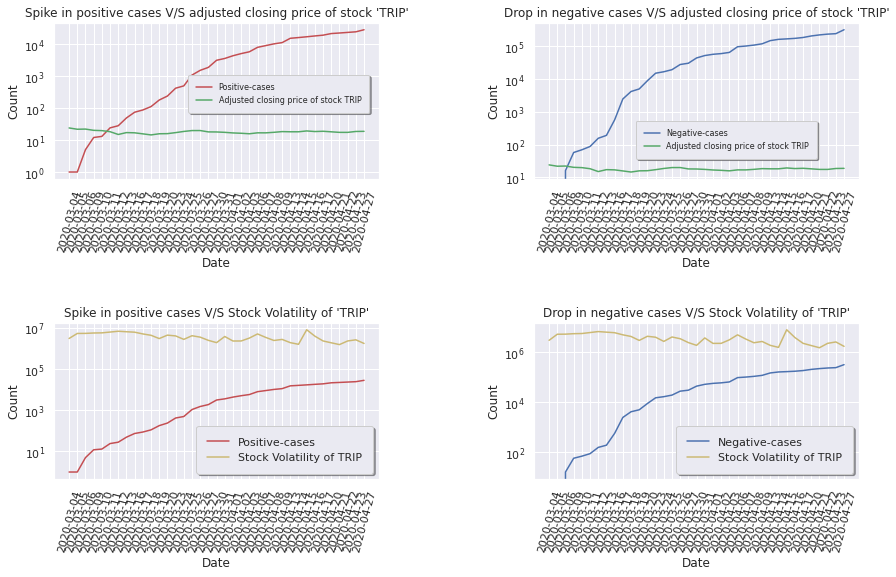

In [0]:
#We'd just like to see if there is any relation between the stock price and the spike in positive cases when plotted on a graph

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.tight_layout(pad=10.0)
sns.set()
axes[0][0].set_yscale('log')
axes[1][0].set_yscale('log')
axes[0][1].set_yscale('log')
axes[1][1].set_yscale('log')
axes[0][0].plot(tx_nm_stock['date'],tx_nm_stock["positive"],'-r', label='Positive-cases');
axes[0][0].tick_params(axis='x', labelrotation=75);
axes[0][0].plot(tx_nm_stock["date"],tx_nm_stock["Adj Close"],'-g',label='Adjusted closing price of stock TRIP');
axes[0][0].set(title = "Spike in positive cases V/S adjusted closing price of stock 'TRIP'",xlabel = "Date",ylabel = "Count");
axes[0][0].legend(loc='best', shadow=True , prop={'size': 8}, bbox_to_anchor = (0.4,0.4), fancybox=True, framealpha=1, borderpad=1);

axes[0][1].plot(tx_nm_stock['date'],tx_nm_stock["negative"],'-b', label='Negative-cases');
axes[0][1].tick_params(axis='x', labelrotation=75);
axes[0][1].plot(tx_nm_stock["date"],tx_nm_stock["Adj Close"],'-g',label='Adjusted closing price of stock TRIP');
axes[0][1].set(title = "Drop in negative cases V/S adjusted closing price of stock 'TRIP'",xlabel = "Date",ylabel = "Count");
axes[0][1].legend(loc='best', shadow=True, prop={'size': 8}, bbox_to_anchor = (0.3,0.4), fancybox=True, framealpha=1, borderpad=1);

axes[1][0].plot(tx_nm_stock['date'],tx_nm_stock["positive"],'-r', label='Positive-cases');
axes[1][0].tick_params(axis='x', labelrotation=75);
axes[1][0].plot(tx_nm_stock["date"],tx_nm_stock["Volume"],'-y',label='Stock Volatility of TRIP');
axes[1][0].set(title = "Spike in positive cases V/S Stock Volatility of 'TRIP'",xlabel = "Date",ylabel = "Count");
axes[1][0].legend(loc='lower right', shadow=True, fancybox=True, framealpha=1, borderpad=1);

axes[1][1].plot(tx_nm_stock['date'],tx_nm_stock["negative"],'-b', label='Negative-cases');
axes[1][1].tick_params(axis='x', labelrotation=75);
axes[1][1].plot(tx_nm_stock["date"],tx_nm_stock["Volume"],'-y',label='Stock Volatility of TRIP');
axes[1][1].set(title = "Drop in negative cases V/S Stock Volatility of 'TRIP'",xlabel = "Date",ylabel = "Count");
axes[1][1].legend(loc='lower right', shadow=True, fancybox=True, framealpha=1, borderpad=1);

In [0]:
#Basic functions we need ahead in our program of chi square calculation

#Returns the value rounded to 2 decimals
def get_round(val):
  return round(val, 2)

#Returns percentage difference
def get_percentage_difference(col):
  return col.pct_change(periods = 1)

#Returns difference between expected and observed
def get_difference_exp_obs(obs, exp):
  return((obs - exp) ** 2)/exp


### Hypothesis
Tripadvisor is an American online travel company that offers online hotel reservations as well as bookings for transportation, lodging, travel experiences, and restaurants.
With chi square test, we aim to show whether or not the increase in number of people booking tickets and travelling to/fro(can be identified by adjusted closing price of a stock) is related to the spike in number of positive cases of COVID.

**Null Hypothesis:**

H0: The change in the adjusted closing price of stock "TRIP" is independent of the rise in positive cases.

**Alternate Hypothesis:**

H1: The adjusted closing price of stock "TRIP" is related to the number of positive cases of COVID.


In [0]:
#We look at the independence/dependence between adj close price and the change in positive cases

adj_close_percent_diff = pd.Series(get_percentage_difference(tx_nm_stock['Adj Close']))
cases_percent_diff = pd.Series(get_percentage_difference(tx_nm_stock['positive']))

#print(adj_close_percent_diff)
tx_nm_stock['adjusted_closeprice_percent_change'] = adj_close_percent_diff
tx_nm_stock['positivecase_percent_change'] = cases_percent_diff

#To remove the headers we assign the rows from row1 instead of 0 to the df
tx_nm_stock = tx_nm_stock.iloc[1:]

#Calculating difference between the percentage differences
adjstockprice = pd.Series(get_percentage_difference(tx_nm_stock['adjusted_closeprice_percent_change']))
cases = pd.Series(get_percentage_difference(tx_nm_stock['positivecase_percent_change']))

tx_nm_stock['stockprice_slope'] = adjstockprice
tx_nm_stock['cases_slope'] = cases

#To remove the headers we assign the rows from row1 instead of 0 to the df
tx_nm_stock = tx_nm_stock.iloc[1:]

In [0]:
#Marking the confusion matrix - Positives and Negatives
tx_nm_stock['Lpositive'] = np.where(tx_nm_stock['cases_slope'] >= 0, 'Positive', 'Negative')
tx_nm_stock['Lstock'] = np.where(tx_nm_stock['stockprice_slope'] >= 0, 'Positive', 'Negative')
tx_nm_stock.iloc[:,20:-1].head(1)

,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,state,Open,High,Low,Close,Adj Close,Volume,adjusted_closeprice_percent_change,positivecase_percent_change,stockprice_slope,cases_slope,Lpositive
2,0.0,0.0,4.0,4.0,"TX,NM",20.92,22.16,20.799999,22.0,22.0,5317300,0.01196,4.0,-1.134601,inf,Positive


alpha = 0.05

We will calculate degree of freedom as:

degree_of_freedom = (2 - 1) * (2 - 1) = 1

We reject when p-value < alpha for a given degree of freedom. (in our case its 1)

Reference:-

http://courses.atlas.illinois.edu/spring2016/STAT/STAT200/pchisq.html


Therefore if our p-value comes out to be less than alpha, then we reject the null hypothesis.





In [0]:
#Forming the table for True positives(TP), False Positives(FP) - Type1 error, True Negatives(TN), False Negatives(FN) - Type2error 
Q = pd.pivot_table(tx_nm_stock, index = ['Lpositive'], columns=['Lstock'], aggfunc=len, fill_value=0)
Q = Q['Adj Close']
Q

true_positives = Q['Positive']['Positive']
true_negatives = Q['Negative']['Negative']
false_positives = Q['Positive']['Negative']
false_negatives = Q['Negative']['Positive']

#Calculating precision and recall
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)

print("The precision is ",precision)
print("The recall is ",recall)


The precision is  0.4166666666666667
The recall is  0.29411764705882354


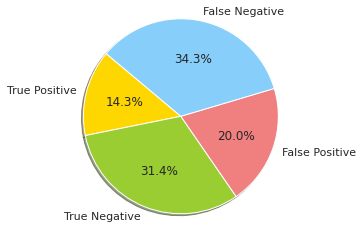

In [0]:
#Visualizing the percentage of TP, TN, FP, FN
labels = ['True Positive','True Negative','False Positive','False Negative']
sizes = [true_positives, true_negatives, false_positives, false_negatives]
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
plt.pie(sizes, labels = labels, colors = colors, autopct = '%1.1f%%', shadow = True, startangle = 140)
plt.axis('equal')
plt.show()


In [0]:
#Now we get the no. of days where TP, TN, FP, FN are observed as per our conditions
stats_table = tx_nm_stock.groupby(['Lpositive','Lstock'])['date'].count().reset_index()
print(stats_table)
stats_table.columns = ['Lpositive','Lstock','noOfDates']
print(stats_table)

  Lpositive    Lstock  date
0  Negative  Negative    11
1  Negative  Positive     7
2  Positive  Negative    12
3  Positive  Positive     5
  Lpositive    Lstock  noOfDates
0  Negative  Negative         11
1  Negative  Positive          7
2  Positive  Negative         12
3  Positive  Positive          5


In [0]:
#To get total number of days of positive spike and negative drop we do below.

#We need the total sum to get the expected values
agg_count = stats_table['noOfDates'].sum()
no_of_days = agg_count

#Two variables in consideration
v1 = 'Lpositive'
v2 = 'Lstock'

#Checking the conditions for TP, FP, TN, FN
cond1 = (stats_table[v1] == 'Positive')
cond2 = (stats_table[v2] == 'Positive')
cond3 = (stats_table[v1] == 'Negative')
cond4 = (stats_table[v2] == 'Negative')

#Filtering on those conditions
temp_pos_table1 = stats_table[cond1]
temp_pos_table2 = stats_table[cond2]
temp_neg_table1 = stats_table[cond3]
temp_neg_table2 = stats_table[cond4]

#Getting the ratios
ratio_pos1 = temp_pos_table1.noOfDates.sum() / no_of_days
ratio_pos2 = temp_pos_table2.noOfDates.sum() / no_of_days

#Just rounding it off to nearest 2 decimals
total_cases = get_round(ratio_pos1)
total_stockprices = get_round(ratio_pos2)

#The observed values for TP, TN, FP, FN
obs_pos_pos = stats_table[cond1 & cond2].noOfDates.sum()
obs_pos_neg = stats_table[cond1 & cond4].noOfDates.sum()
obs_neg_pos = stats_table[cond3 & cond2].noOfDates.sum()
obs_neg_neg = stats_table[cond3 & cond4].noOfDates.sum()

#Alternate cases
comp_tot_cases = 1 - total_cases
comp_tot_stock = 1 - total_stockprices

#Calculation of expected values
exp_pos_pos = total_cases * total_stockprices * no_of_days
exp_pos_neg = total_cases * comp_tot_stock * no_of_days
exp_neg_pos = comp_tot_cases * total_stockprices * no_of_days
exp_neg_neg = comp_tot_cases * comp_tot_stock * no_of_days



In [0]:
#Calculating the sum of (obs - exp) ^ 2 / exp
term1 = get_difference_exp_obs(obs_pos_pos, exp_pos_pos)
term2 = get_difference_exp_obs(obs_pos_neg, exp_pos_neg)
term3 = get_difference_exp_obs(obs_neg_pos, exp_neg_pos)
term4 = get_difference_exp_obs(obs_neg_neg, exp_neg_neg)

results = term1 + term2 + term3 + term4
results

0.3539939021190341

From http://courses.atlas.illinois.edu/spring2016/STAT/STAT200/pchisq.html

From above link, we get p-value as 0.5519 for df = 1 and chi sq value of 0.3539939021190341


In [0]:
p_value = 0.5519 #after looking up on the link with chi sq value as 0.09676343009676323 and df = 1
alpha = 0.05 #threshold
print("The p-value is",p_value)
if(p_value < alpha):
  print("The result is significant at alpha and we reject the null hypothesis.")
  print("Thus we can say that the value of stock 'TRIP' is related to the number of positive cases of COVID.")
else:
  print("The result is not significant at alpha and we fail to reject the null hypothesis.")
  print("Thus we can say that the change in the adjusted closing price of stock 'TRIP' is independent of the rise in positive cases.")

The p-value is 0.5519
The result is not significant at alpha and we fail to reject the null hypothesis.
Thus we can say that the change in the adjusted closing price of stock 'TRIP' is independent of the rise in positive cases.


**Conclusion:**

The above chi-square test shows that the change in value of the stock's closing price is independent of the rise in positive cases; now this could be because - maybe people who were tested positive in the states of Texas and new Mexico did not use TripAdvisor much to book flights/hotels but used some other means to travel. This result is plainly based on the data at hand. 

The graphs plotted above do show the independent nature of both the factors considered.

#Creative Inference 2

###Hypothesis
H0: The onset of coronavirus has caused a distruption in the US China trade relations.

H1: The US China trade relations are statistically unaffected.


We can measure this by calculating the difference in the projected values for March 2020 for import and export. We specifically chose March because the US was affected most by the virus in late february and early-mid march(As shown in the Covid Dataset). 

In [0]:
x_df = pd.read_excel("USCensusDatasetByCountry.xlsx")
china_census = x_df[x_df["CTYNAME"] == "China"]

In [0]:
#Calculate the differences in predictions for the year 2020
print("AR 3:", AR(3, china_census["IMAR"].to_numpy(), 1))
print("AR 5:", AR(5, china_census["IMAR"].to_numpy(), 1))
print("EWMA:", EWMA(china_census["IMAR"].to_numpy(), 0.5, 1))

Real Data [19805.426244]
Predicted Values [36271.744131346575]
AR 3: {'MAPE %': 83.14043678981665, 'MSE': 271139624.7671498}
Real Data [19805.426244]
Predicted Values [37289.11283075301]
AR 5: {'MAPE %': 88.2772547854134, 'MSE': 305679296.66380715}
Real Data [19805.426244]
Predicted Values [26659.79947013768]
EWMA: {'MAPE %': 34.6085620258448, 'MSE': 46982432.3231931}


In [0]:
#Exports March
print("AR 3:", AR(3, china_census["EMAR"].to_numpy(), 1))
print("AR 5:", AR(5, china_census["EMAR"].to_numpy(), 1))
print("EWMA:", EWMA(china_census["EMAR"].to_numpy(), 0.5, 1))

Real Data [7971.889801]
Predicted Values [10485.732904507051]
AR 3: {'MAPE %': 31.533841614214392, 'MSE': 6319407.149049961}
Real Data [7971.889801]
Predicted Values [9584.596179858958]
AR 5: {'MAPE %': 20.22991309609747, 'MSE': 2600821.8644123715}
Real Data [7971.889801]
Predicted Values [9372.506953776516]
EWMA: {'MAPE %': 17.56944949992687, 'MSE': 1961728.408651793}


###Conclusion
While the imports were infact affected by the virus significantly the exports stayed very close to the predicted values. But since most of the United States’ largest exports to China consist of crops or raw materials according to https://www.chinabusinessreview.com/what-america-exports-to-china/ its safe to say that the chances of the exports going down were less to begin with.

## Creative Inference 3- Regression<br>

I wanted to understand the correlation between various columns of the covid and X dataset and so I combined them into one and plotted a heatmap to visualize the correlation values and decide the columns for my inference.<br>



In [0]:
#Loading Covid data 
covid=pd.read_csv("daily.csv")
states = ['TX','NM']
covid = full_data[full_data.state.isin(states)] 
covid=covid.groupby(['date']).sum().reset_index()
covid = covid.fillna("0")
covid = covid.fillna(texas_newmexico_data.mean())
covid['death'] = covid['death'].astype(int)
covid.astype(int)

,date,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,death,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,20200304,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,48,0,0,0,0,0
1,20200305,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,48,0,0,0,0,0
2,20200306,5,16,0,0,0,0,0,0,0,0,0,0,21,21,21,83,0,0,0,4,4
3,20200307,8,48,0,0,0,0,0,0,0,0,0,0,56,56,56,83,0,0,32,3,35
4,20200308,8,48,0,0,0,0,0,0,0,0,0,0,56,56,56,83,0,0,0,0,0
5,20200309,12,57,0,0,0,0,0,0,0,0,0,0,69,69,69,83,0,0,9,4,13
6,20200310,13,69,0,0,0,0,0,0,0,0,0,0,82,82,82,83,0,0,12,1,13
7,20200311,24,87,0,0,0,0,0,0,0,0,0,0,111,111,111,83,0,0,18,11,29
8,20200312,28,155,0,0,0,0,0,0,0,0,0,0,183,183,183,83,0,0,68,4,72
9,20200313,49,190,0,0,0,0,0,0,0,0,0,0,239,239,239,83,0,0,35,21,56


In [0]:
#Merging the two datasets and filtering a little to match dimensions and number of rows
covid=covid[['negative','positive','hospitalizedCurrently','recovered','death','total','negativeIncrease','positiveIncrease','deathIncrease','totalTestResultsIncrease']]
X=pd.read_csv('TRIP.csv')
X=X[['Open','High','Low','Close','Adj Close','Volume']]
merged=pd.concat([X, covid], axis=1)
merged=merged.head(42)

After this we first performed Multiple Linear Regression by considering various columns of the X dataset as the vector of independent variables and a single column of covid dataset as the dependent variable. After experimenting with various columns the best RMSE error achieved was 88.51390270429455 on the number of deaths column. <br>
It is agreed that the error value is not so great but given the limited amount of training data, we believe it seems good enough and there is a clear relationship between the change in the stock values of TripAdvisor (which can be equated to number of flights and transactions which give us a measure of travel) with the number of deaths. <br>
This seems like as the number of people who travel increases, more people get infected and hence the number of deaths indirectly increases. 


<b> Error functions:<b>

In [0]:
#Formula=(sum(abs(Yi-Y_hat))/Yi)*100/n
def mape(y_hat,test):
  error=0
  for i in range(len(test)):
    error=error+((abs(test[i]-y_hat[i])/test[i])*100)
  return error/len(test)

#Formula=sum((Yi-Y_hat)^2)/n
def mse(y_hat,test):
  error=0
  for i in range(len(test)):
    error=error+((test[i]-y_hat[i])*(test[i]-y_hat[i]))
  return error/len(test)

#Formula=sqrt(sum((Yi-Y_hat)^2)/n)
import math
def rmse(y_hat,test):
  error=0
  for i in range(len(test)):
    error=error+((test[i]-y_hat[i])*(test[i]-y_hat[i]))
  return math.sqrt(error/len(test))

def plot(X1,Y1,Y1_hat):
  plt.plot(X1, Y1, 'r', label='Original data') 
  plt.plot(X1, Y1_hat, 'g', label='Fitted line') 
  plt.legend() 
  plt.show()

<b>Multiple Linear Regression</b>

In [0]:
#Selecting a vector of Independent variables
X.values.tolist()
#Selecting the dependent variable
test=merged[['death']].values.tolist()
#Idea: Understand the relationship between the various features related to stock values(flight transactions) and the number of deaths

#Implementing the formula: b_hat=(x.T*x)^-1*x.T*y
emp=np.ones((len(test),1))
x=np.matrix(X)
x=np.concatenate((emp,x),axis=1)     
t=x.T
prod=np.matmul(t,x)
inv=np.linalg.pinv(prod)
res_x=np.matmul(inv,t)
y=np.matrix(test)

b_hat=np.matmul(res_x,y)

#Implementing the formula:y_hat=x*b_hat
y_hat=np.matmul(x,b_hat)

In [0]:
#Calculating error scores between the true value and the predicted value
print("MAPE=",mape(y_hat,test))
print("MSE=",mse(y_hat,test))
print("RMSE=",rmse(y_hat,test))

MAPE= [[inf]]
MSE= [[7834.71097195]]
RMSE= 88.51390270429457


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


In an attempt to decrease the error a little more, we tried our hand at Simple Linear Regression with Volume as the Independent feature and death as the dependent feature after lots of experimenting.<br>
This combination gives an RMSE of 9.3757042719415 which seems really good and supports our above inference and idea.<br>

<b>Note:</b> MAPE comes out to be inf as there are lots of 0's in the data avaialble to us(true values) and division by zero leads to inf value.

<b>Simple Linear Regression</b>

In [0]:
#Similar to Assignment 6
#Formulae
#b1_hat = (sum(X_i*Y_i) - n*Xbar*Ybar)/(sum(Xi*Xi) - n*Xbar*Xbar)
#b0_hat = Ybar - b1_hat*Xbar
#Y_i_hat = b0_hat + b1_hat*X_i
#Calculating the value of b1_hat
def calculate_b1hat(X,Y):
    b1_hat = (np.sum(X*Y) - (np.mean(X)*np.mean(Y)*len(X)))/(np.sum(X*X) - (len(X)*np.mean(X)*np.mean(X)))
    return b1_hat
#Calculating the value of b0_hat
def calculate_b0hat(X,Y,b1_hat):
    b0_hat = np.mean(Y) - (b1_hat*np.mean(X))
    return b0_hat
#Calculating the value of Y_hat 
def calculate_Yhat(b0_hat, b1_hat, X):
  Y_hat = b0_hat + (b1_hat*X)
  return Y_hat

In [0]:
#Choosing features for performing simple linear regression
#Independent feature is Volume from X dataset and dependent feature is deathIncrease from Covid dataset
#Intention is to analyze the relationship between the number of flights booked on TripAdvisor(value of Volume) and the increase in number of deaths
X1=X['Volume'].values
Y1=merged['deathIncrease'].values
#Calling the above functions
b11_hat = calculate_b1hat(X1, Y1)
b01_hat = calculate_b0hat(X1, Y1, b11_hat)
Y1_hat = calculate_Yhat(b01_hat, b11_hat, X1)


MAPE= 68.05521515698895
MSE= 87.90383059490209
RMSE= 9.3757042719415


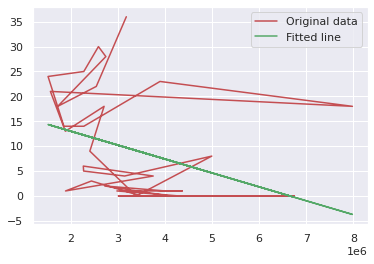

In [0]:
#Calculating error scores between the true value and the predicted value
print("MAPE=",mape(Y1,Y1_hat))
print("MSE=",mse(Y1,Y1_hat))
print("RMSE=",rmse(Y1,Y1_hat))
plot(X1,Y1,Y1_hat)

Since we computed the correlations before performing regression and there were some evident correlations, We think that regression works for this task and provides us with some interesting insights.